# Kaggle Project : House Credit Default Risk

Summary: Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities. Details of project can be find here : https://www.kaggle.com/c/home-credit-default-risk

 ** 1) Installing required packages**

In [1]:
import pandas as pd, numpy as np, os
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split as tts
import csv
from hyperopt import STATUS_OK
import time
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
tpe_algo=tpe.suggest
from hyperopt import Trials
from sklearn.metrics import roc_auc_score as auc,precision_score as ps, roc_curve,recall_score as rs,accuracy_score as ase,f1_score as f1
from sklearn.metrics import classification_report,confusion_matrix,log_loss
from hyperopt import fmin
import time

**2) Reading Training and Testing files**

The dataset has seven files as mentioned here :https://www.kaggle.com/c/home-credit-default-risk/data.
Here i am using the training and testing set after mrging all the respective files with "application_train.csv" and "application_test.csv", which include few feature engineering as well.

In [4]:
train=pd.read_csv("merged_application_train.csv",index_col=0)
test=pd.read_csv("merged_application_test.csv",index_col=0)


**3) Deling with Missing values in features**

**For Categorical features:** There is only one categorical feature "currency_type" which missing data. Impute those instances with "no info"

In [6]:
train["currency_type"]=train["currency_type"].fillna("no info")
test["currency_type"]=test["currency_type"].fillna("no info")

4) Removed numerical features having more than 50% of missing data

In [8]:
columns_high_missing=train.columns[train.isnull().mean()>0.5]
len(columns_high_missing)
train=train.drop(columns_high_missing,axis=1)
test=test.drop(columns_high_missing,axis=1)

5) Checking how balance is Target variables classes are!

In [11]:
train.TARGET.value_counts()

0    282682
1     24825
Name: TARGET, dtype: int64

6) Just checking the train data

In [86]:
pd.set_option("display.max_columns",500)
train.select_dtypes(["float64"]).head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,cumulative_pending_amount,completed_contract,Active_contract,Signed_contract,Approved_contract,cumulative_pending_amount_Active,cumulative_pending_amount_Completed,cumulative_pending_amount_Signed,cumulative_pending_amount_Approved,cumulative_due_days_Active,cumulative_due_days_Completed,cumulative_due_days_Signed,cumulative_due_days_Approved,same_day,after deadline,before deadline,mean_amt_payment,credit_payment,previous_loan_counts,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,previous_AMT_APPLICATION_sum,previous_AMT_CREDIT_count,previous_AMT_CREDIT_mean,previous_AMT_CREDIT_max,previous_AMT_CREDIT_min,previous_AMT_CREDIT_sum,previous_AMT_DOWN_PAYMENT_count,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_DOWN_PAYMENT_max,previous_AMT_DOWN_PAYMENT_min,previous_AMT_DOWN_PAYMENT_sum,previous_AMT_GOODS_PRICE_count,previous_AMT_GOODS_PRICE_mean,previous_AMT_GOODS_PRICE_max,previous_AMT_GOODS_PRICE_min,previous_AMT_GOODS_PRICE_sum,previous_HOUR_APPR_PROCESS_START_count,previous_HOUR_APPR_PROCESS_START_mean,previous_HOUR_APPR_PROCESS_START_max,previous_HOUR_APPR_PROCESS_START_min,previous_HOUR_APPR_PROCESS_START_sum,previous_NFLAG_LAST_APPL_IN_DAY_count,previous_NFLAG_LAST_APPL_IN_DAY_mean,previous_NFLAG_LAST_APPL_IN_DAY_max,previous_NFLAG_LAST_APPL_IN_DAY_min,previous_NFLAG_LAST_APPL_IN_DAY_sum,previous_RATE_DOWN_PAYMENT_count,previous_RATE_DOWN_PAYMENT_mean,previous_RATE_DOWN_PAYMENT_max,previous_RATE_DOWN_PAYMENT_min,previous_RATE_DOWN_PAYMENT_sum,previous_RATE_INTEREST_PRIMARY_count,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_sum,previous_RATE_INTEREST_PRIVILEGED_count,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_sum,previous_DAYS_DECISION_count,previous_DAYS_DECISI

7) In numerical feature **"DAYS_EMPLOYED"**, 365243 represents null value, replacing them with np.nan

In [10]:
train["DAYS_EMPLOYED"]=train["DAYS_EMPLOYED"].replace(365243,np.nan)
test["DAYS_EMPLOYED"]=test["DAYS_EMPLOYED"].replace(365243,np.nan)


8) Impute the missing data in training and testing numerical features with training set median.

In [ ]:
columns=train.drop(["SK_ID_CURR"],axis=1).select_dtypes(["float64"]).columns
for i in columns:
    train[i]=train[i].replace(np.nan,train[i].median())
    test[i]=test[i].replace(np.nan,train[i].median())
    print("imputation for feature {} : DONE".format(i))

9) Creating dummies of training set and stratified splitting into training and hold out set

In [12]:
train=train.sample(frac=1)
X=train.drop(["TARGET","SK_ID_CURR"],axis=1)
Xdummies=pd.get_dummies(X,drop_first=True)
features=Xdummies.columns
Y=train["TARGET"]
x1,x2,y1,y2=tts(Xdummies,Y,test_size=0.2,stratify=Y)

10) Used **Sequential based model optimization** with **tree parzen estimator** for tuning the hyperparameters of xgboost model. Used hyperopt package for implementiong this method. Details are pretty well illustrated here : https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0

In [35]:
space = {
    'booster': hp.choice('booster',['gbtree','dart']),
    'eta': hp.loguniform('eta', np.log(0.1), np.log(0.5)),
    'gamma':hp.choice('gamma',[0,6,1,2,3,4,5]),
    'max_depth': hp.choice('max_depth',[5,6,7,8,9,10,11,12]),
    'min_child_weight': hp.quniform('min_child_weight',0,10,1),
    'max_delta_step':hp.quniform('max_delta_step',0,10,1),
    'subsample':hp.uniform('subsample',0.6,0.9),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
'num_boost_round':hp.choice('num_boost_round',[5,10,15,20,25,30,35])}

In [57]:
params={'booster': 'gbtree', 'colsample_bytree': 0.9894752450981222, 'eta': 0.2, 
         'gamma': 3, 'max_delta_step': 10.0, 'max_depth': 5, 'min_child_weight': 3, 
         'reg_alpha': 0.5917352962629567, 'reg_lambda': 0.5337548645253326, 'subsample': 0.8101332183651112,'num_boost_round':25}


11) For tunig the parameters, i used the ratio of cross validation auc score on holdout set to difference in train and hold out auc score after cross validation

In [66]:
# using cv to tune parameters, maximise test score and minimize diff in train and test
def objective(params):
    global iteration
    iteration+=1 
    params["silent"]=1
    params["objective"]="binary:logistic"
    params["scale_pos_weight"]=11
    params["seed"]=7
    start=time.time()
    clf=xgboost.cv(params,dtrain,num_boost_round=params["num_boost_round"],nfold=5,metrics=["auc"],stratified=True,verbose_eval=False)
    best_score=clf["test-auc-mean"].max()/(clf["train-auc-mean"].max()-clf["test-auc-mean"].max())
    loss=10-best_score
    print("best_score for current iteration :{} is :{} with train-auc:{} and test_auc:{}".format(iteration,best_score,clf["train-auc-mean"].max(),clf["test-auc-mean"].max()))
    # writing results to file
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, iteration])
    # return 5 things
    return {'loss': loss, 'params': params, 'iteration': iteration, 'status': STATUS_OK}

12) Write a file to save the results of optimization task, so that later that can be used to get the best parameters.

In [68]:
tpe_algo=tpe.suggest
bayes_trial=Trials()
out_file = 'bayesian_results.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
# Write the headers to the file
writer.writerow(['loss','params','iteration'])
of_connection.close()


In [69]:
global  iteration
iteration = 0
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe_algo, trials = bayes_trial,max_evals=100)


best_score for current iteration :1 is :21.259311485250542 with train-auc:0.7861232 and test_auc:0.7508066
best_score for current iteration :2 is :2.7343146347033027 with train-auc:0.9615666 and test_auc:0.7040718
best_score for current iteration :3 is :2.969958359809872 with train-auc:0.9783748000000001 and test_auc:0.7319302000000001
best_score for current iteration :4 is :3.6200809910180904 with train-auc:0.9430574 and test_auc:0.738936
best_score for current iteration :5 is :8.408889602634625 with train-auc:0.8319566 and test_auc:0.7435342
best_score for current iteration :6 is :14.837315588166463 with train-auc:0.8115673999999998 and test_auc:0.7603234
best_score for current iteration :7 is :11.420901156645446 with train-auc:0.8225866 and test_auc:0.7563606
best_score for current iteration :8 is :11.590061458938749 with train-auc:0.8144964 and test_auc:0.7498028
best_score for current iteration :9 is :4.349135561265783 with train-auc:0.9067876 and test_auc:0.7372672
best_score for

best_score for current iteration :74 is :55.99090629800293 with train-auc:0.7420216 and test_auc:0.7290015999999999
best_score for current iteration :75 is :15.333342937108998 with train-auc:0.7936698 and test_auc:0.7450778
best_score for current iteration :76 is :26.949036761416377 with train-auc:0.7871958000000001 and test_auc:0.7590304
best_score for current iteration :77 is :3.4942560002145493 with train-auc:0.938442 and test_auc:0.7296328
best_score for current iteration :78 is :7.117293324663144 with train-auc:0.8263777999999998 and test_auc:0.7245732
best_score for current iteration :79 is :56.34252880664757 with train-auc:0.7424940000000001 and test_auc:0.7295456
best_score for current iteration :80 is :2.994911865217047 with train-auc:0.979387 and test_auc:0.7342284
best_score for current iteration :81 is :20.57975089958987 with train-auc:0.7904188000000001 and test_auc:0.753791
best_score for current iteration :82 is :4.4033530196680974 with train-auc:0.9086862 and test_auc:0

13) Used tuned parameters for training the xgboost model

In [16]:
#with tuned hyperparameters
params={'booster': 'gbtree', 'colsample_bytree': 0.9894752450981222, 'eta': 0.33574140004127845, 
         'gamma': 3, 'max_delta_step': 10.0, 'max_depth': 5, 'min_child_weight': 3, 
         'reg_alpha': 0.5917352962629567, 'reg_lambda': 0.5337548645253326, 'subsample': 0.8101332183651112, 
         'silent': 1, 'scale_pos_weight': 11, 'objective': 'binary:logistic', 'seed': 7}
params["eval_metric"]=["auc","logloss"]
dtrain=xgboost.DMatrix(x1,y1,nthread=-1)
dtest=xgboost.DMatrix(x2,y2,nthread=-1)
evallist=[(dtrain,"train"),(dtest,"test")]
model=xgboost.train(params,dtrain,num_boost_round=200,evals=evallist,early_stopping_rounds=8)


[0]	train-auc:0.717784	train-logloss:0.648564	test-auc:0.707561	test-logloss:0.649492
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 8 rounds.
[1]	train-auc:0.728749	train-logloss:0.624477	test-auc:0.716072	test-logloss:0.626239
[2]	train-auc:0.735908	train-logloss:0.609697	test-auc:0.722069	test-logloss:0.612135
[3]	train-auc:0.744363	train-logloss:0.598446	test-auc:0.727707	test-logloss:0.601281
[4]	train-auc:0.751532	train-logloss:0.590439	test-auc:0.732758	test-logloss:0.593657
[5]	train-auc:0.755126	train-logloss:0.58415	test-auc:0.735824	test-logloss:0.587699
[6]	train-auc:0.760531	train-logloss:0.57918	test-auc:0.739865	test-logloss:0.583062
[7]	train-auc:0.763913	train-logloss:0.575127	test-auc:0.741595	test-logloss:0.579339
[8]	train-auc:0.768249	train-logloss:0.57066	test-auc:0.744563	test-logloss:0.575425
[9]	train-auc:0.771119	train-logloss:0.567648	test-auc:0.746221	test-logloss:0.57

[93]	train-auc:0.854106	train-logloss:0.482245	test-auc:0.755541	test-logloss:0.514951
[94]	train-auc:0.854741	train-logloss:0.481263	test-auc:0.755453	test-logloss:0.514172
[95]	train-auc:0.855138	train-logloss:0.481345	test-auc:0.755277	test-logloss:0.514469
[96]	train-auc:0.855329	train-logloss:0.481256	test-auc:0.755256	test-logloss:0.514431
[97]	train-auc:0.85607	train-logloss:0.479633	test-auc:0.755164	test-logloss:0.513292
[98]	train-auc:0.856592	train-logloss:0.478944	test-auc:0.755026	test-logloss:0.512912
[99]	train-auc:0.85734	train-logloss:0.47784	test-auc:0.755166	test-logloss:0.512065
[100]	train-auc:0.858132	train-logloss:0.47763	test-auc:0.754842	test-logloss:0.512256
[101]	train-auc:0.85912	train-logloss:0.477261	test-auc:0.754409	test-logloss:0.51234
[102]	train-auc:0.859787	train-logloss:0.476982	test-auc:0.754015	test-logloss:0.51241
[103]	train-auc:0.859942	train-logloss:0.476366	test-auc:0.753816	test-logloss:0.512046
[104]	train-auc:0.860238	train-logloss:0.47577

[187]	train-auc:0.898739	train-logloss:0.427807	test-auc:0.747528	test-logloss:0.483634
[188]	train-auc:0.898995	train-logloss:0.427358	test-auc:0.747387	test-logloss:0.483332
[189]	train-auc:0.899446	train-logloss:0.426956	test-auc:0.747273	test-logloss:0.483231
[190]	train-auc:0.899688	train-logloss:0.426353	test-auc:0.74724	test-logloss:0.482908
[191]	train-auc:0.900046	train-logloss:0.425958	test-auc:0.746926	test-logloss:0.482735
[192]	train-auc:0.900109	train-logloss:0.425957	test-auc:0.746846	test-logloss:0.48285
[193]	train-auc:0.900494	train-logloss:0.425117	test-auc:0.746637	test-logloss:0.482538
[194]	train-auc:0.900855	train-logloss:0.425144	test-auc:0.746468	test-logloss:0.482767
[195]	train-auc:0.90118	train-logloss:0.424044	test-auc:0.746273	test-logloss:0.481884
[196]	train-auc:0.90165	train-logloss:0.422972	test-auc:0.746215	test-logloss:0.480911
[197]	train-auc:0.902254	train-logloss:0.422306	test-auc:0.746077	test-logloss:0.480535
[198]	train-auc:0.902649	train-loglo

14) Calculate the importance of each feature using xgboost.get_score , based on information gain. Further, calculated the cumulative score with number of features used, to get an idea of number of features which flattened out the cumulative score.

In [17]:
ft_score=model.get_score(importance_type='gain')
df_score=pd.DataFrame({"feature":list(ft_score.keys()),"gain_score":list(ft_score.values())})
sort_df_score=df_score.sort_values(by="gain_score",ascending=False)
sort_df_score["cum_score"]=sort_df_score.gain_score.cumsum()
sort_df_score["cumulative_improvement"]=100*sort_df_score["cum_score"]/sort_df_score.gain_score.sum()
sort_df_score["number_of_features"]=np.arange(1,sort_df_score.shape[0]+1,1)


15) Using only those number of features, corresponding to whom the cumulative score flattened out

In [18]:
feature_included=sort_df_score.feature.values


16) Calculating permutation importance of each feature present in above "feature_included". Used the details shared here: https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

In [44]:
def importance(x1,shuffle):
    train_features=x1[feature_included].columns
    y=y1.copy()
    if shuffle:
        y=y1.copy().sample(frac=1)
    dtrain=xgboost.DMatrix(x1[train_features],y)
    params={'booster': 'dart', 'colsample_bytree': 0.9935989916678375, 'eta': 0.25932302857840434,
        'gamma': 6, 'max_delta_step': 0.0, 'max_depth': 5, 'min_child_weight': 3, 'num_boost_round': 35,
        'reg_alpha': 0.45346050428581897, 'reg_lambda': 0.515471773137645, 'subsample': 0.7720558893813168,
        'silent': 1, 'objective': 'binary:logistic', 'scale_pos_weight': 11, 'seed': 7}
    # Fit the model
    clf = xgboost.train(params,dtrain, num_boost_round=34)
    ft_score=clf.get_score(importance_type='gain')
    imp_df=pd.DataFrame({"feature":list(ft_score.keys()),"gain_score":list(ft_score.values())})
    return imp_df


17) Calculate the actual and null gain importance of each feature using xgboost. To get, null importance of each feature, 80 random iterations are used, this can be varied. For each iteration, a null importance will be obtained for each feature used.

In [45]:
actual_imp_df=importance(x1,shuffle=False)

In [ ]:
null_imp_df = pd.DataFrame()
nb_runs = 80
start = time.time()
dsp = ''
for i in range(nb_runs):
    imp_df = importance(x1,shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)

18) Compare the actual importance with the null importance. The idea is, actual importance should be better than null importance. This can be visualized for each feature, by plotting the corresponding null importance of each iteration and then see how far is the actual importance from that distribution of null importances. Ideally, it shouldn't be in the 50th percentile of distribution. Gain score is the gain in information when using feature in comparison with null importance of that feature. Used 75th percentile value for compting the gain score. It can be set o higher percentil for aggressive selection of features.

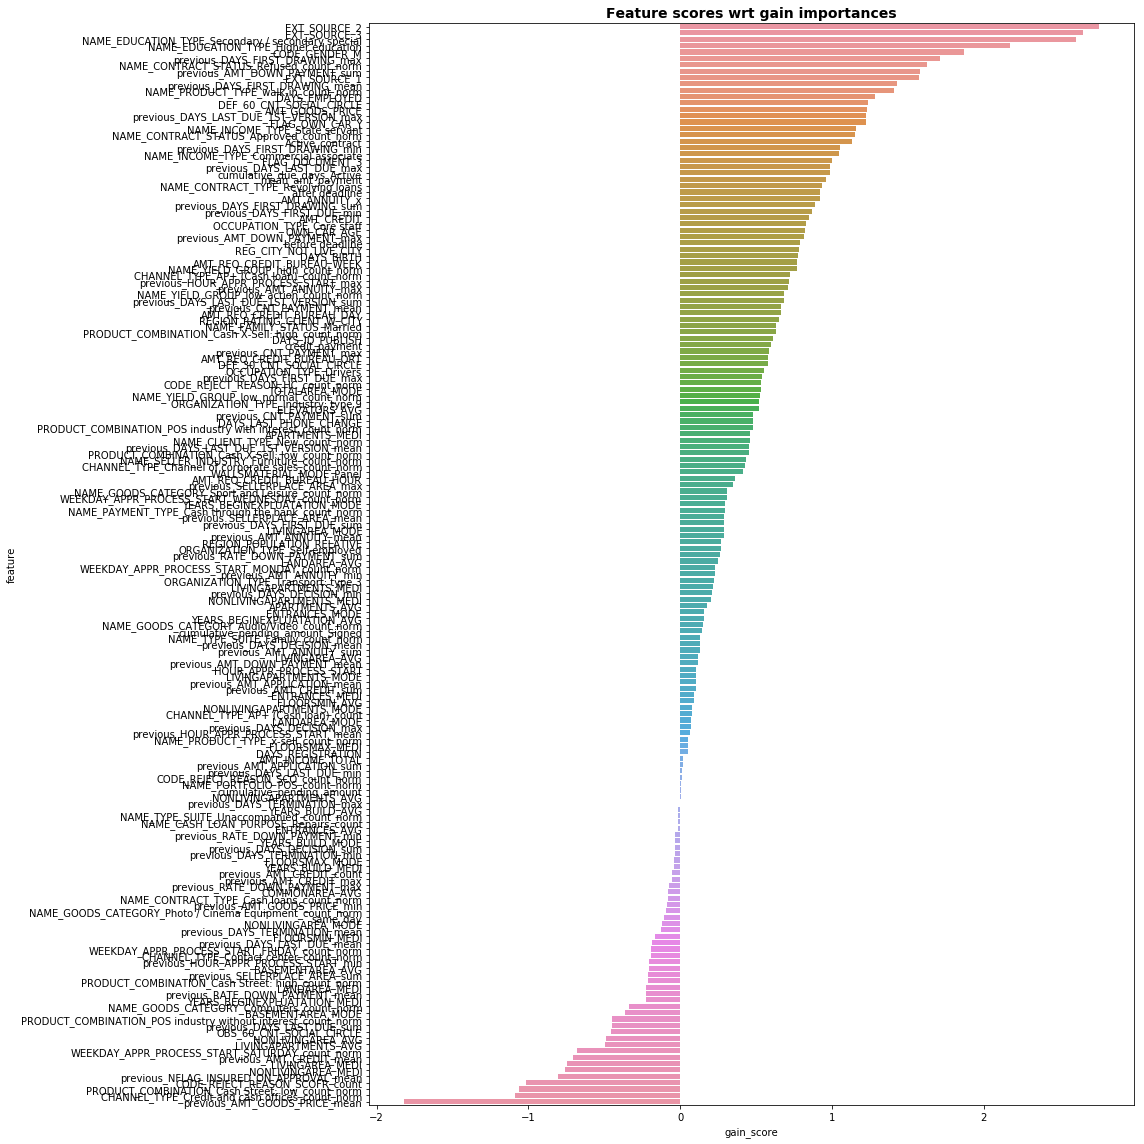

In [52]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'gain_score'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'gain_score'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    feature_scores.append((_f,gain_score))
scores_df = pd.DataFrame(feature_scores, columns=['feature','gain_score'])
plt.figure(figsize=(16, 16))
ax = plt.subplot()
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False), ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()


19) Only using those features, for whom gain score is greater than 0

In [25]:
imp_feature=scores_df[scores_df["gain_score"]>0]["feature"].values


20) Training xgboost model after selecting feature based on permutation importance

In [50]:
params={'booster': 'dart', 'colsample_bytree': 0.9935989916678375, 'eta': 0.25932302857840434,
        'gamma': 6, 'max_delta_step': 5, 'max_depth': 5, 'min_child_weight': 3,
        'reg_alpha': 0.45346050428581897, 'reg_lambda': 0.515471773137645, 'subsample': 0.7720558893813168,
        'silent': 1, 'objective': 'binary:logistic', 'scale_pos_weight': 10, 'seed': 7}
params["eval_metric"]=["logloss","auc"]


In [ ]:
dtrain=xgboost.DMatrix(x1[imp_feature],y1,nthread=-1)
dtest=xgboost.DMatrix(x2[imp_feature],y2,nthread=-1)
evallist=[(dtrain,"train"),(dtest,"test")]
model=xgboost.train(params,dtrain,num_boost_round=61,evals=evallist,early_stopping_rounds=10)


[0]	train-logloss:0.648589	train-auc:0.717867	test-logloss:0.649247	test-auc:0.706828
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[1]	train-logloss:0.620914	train-auc:0.725606	test-logloss:0.621676	test-auc:0.714881
[2]	train-logloss:0.60254	train-auc:0.733691	test-logloss:0.603752	test-auc:0.721634
[3]	train-logloss:0.587973	train-auc:0.738102	test-logloss:0.589457	test-auc:0.725337
[4]	train-logloss:0.576995	train-auc:0.743663	test-logloss:0.578799	test-auc:0.729839
[5]	train-logloss:0.568879	train-auc:0.748785	test-logloss:0.571237	test-auc:0.733757
[6]	train-logloss:0.561183	train-auc:0.754247	test-logloss:0.563891	test-auc:0.737177
[7]	train-logloss:0.555948	train-auc:0.7583	test-logloss:0.558926	test-auc:0.73984
[8]	train-logloss:0.551197	train-auc:0.762144	test-logloss:0.55469	test-auc:0.742024
[9]	train-logloss:0.5468	train-auc:0.764711	test-logloss:0.550776	test-auc:0.743646
[10]	t

21) Creating dummies for testing set and using the trained model for prediction. 

In [28]:
# test, features, 
test_feature=pd.get_dummies(test,drop_first=True)
exclude=list(set(test_feature.columns)-set(imp_feature))
include=list(set(imp_feature)-set(test_feature.columns))
test1=test_feature[imp_feature]

In [49]:
pred=model.predict(xgboost.DMatrix(test1,nthread=-1))
result=pd.DataFrame({"SK_ID_CURR":test_feature.SK_ID_CURR.values,"TARGET":pred})
result.to_csv("submission.csv",index=False)
